# Walmart Sales Forecasting using Tensorflow 

**Goal:** Predict future store sales for Walmart to optimize inventory management and supply planning.

**Dataset:** Kaggle Walmart Recruiting - Store Sales forecasting


In [ ]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ML preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Deep Learning 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Load and Filter Dataset

In [2]:
df = pd.read_csv("train.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Select one store and department
store_id = 1
dept_id = 1
data = df[(df["Store"] == store_id) & (df["Dept"] == dept_id)][["Date", "Weekly_Sales"]].sort_values("Date")


In [3]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


## Preprocess

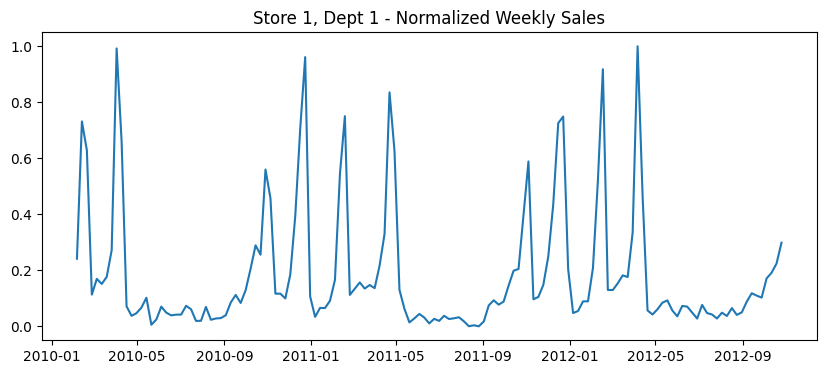

In [4]:
# Scale sales data for LSTM (helps convergence)
scaler = MinMaxScaler(feature_range=(0, 1))
data["Scaled_Sales"] = scaler.fit_transform(data[["Weekly_Sales"]])

plt.figure(figsize=(10, 4))
plt.plot(data["Date"], data["Scaled_Sales"])
plt.title(f"Store {store_id}, Dept {dept_id} - Normalized Weekly Sales")
plt.show()

## Create Sequences

In [6]:
def create_sequences(dataset, seq_length=12): # Next week prediction based on past 12 weeks
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length])
        y.append(dataset[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12  # use past 12 weeks to predict next week
X, y = create_sequences(data["Scaled_Sales"].values, sequence_length)

## Split train / test 

In [7]:
# Split train/test (last 12 samples for test)
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
# Reshape for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (117, 12, 1), Test shape: (14, 12, 1)


## Build LSTM Model

In [9]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

2025-10-20 22:31:33.017253: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-20 22:31:33.044827: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-20 22:31:33.048685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-20 22:31:33.050976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-20 22:31:33.051597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

## Train LSTM Model

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50


2025-10-20 22:33:06.625210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 0.0685 - val_loss: 0.0252
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 0.0685 - val_loss: 0.0252
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0548 - val_loss: 0.0259
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0548 - val_loss: 0.0259
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0546 - val_loss: 0.0090
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0546 - val_loss: 0.0090
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0535 - val_loss: 0.0116
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0535 - val_loss: 0.0116
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0515 - val_loss: 0.0173
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0515 - val_loss: 0.0173
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0523 - val_loss: 0.0240
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0523 - val_loss: 0.0240
Epoch 7/50


## Plot Training History

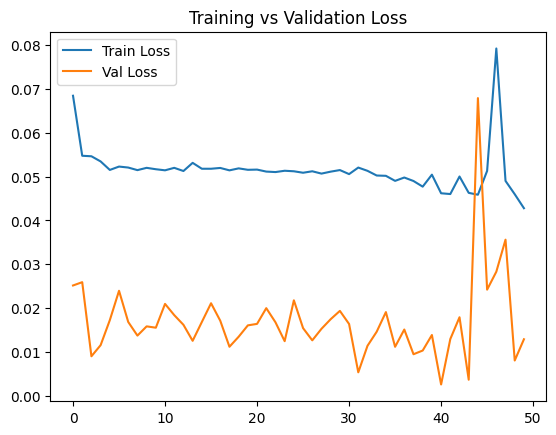

In [12]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Eval LSTM Model

In [13]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_true, pred)
rmse = math.sqrt(mean_squared_error(y_true, pred))
print(f"LSTM MAE: {mae:.2f}, RMSE: {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM MAE: 2235.16, RMSE: 2982.90
LSTM MAE: 2235.16, RMSE: 2982.90


## Visualize Forecast

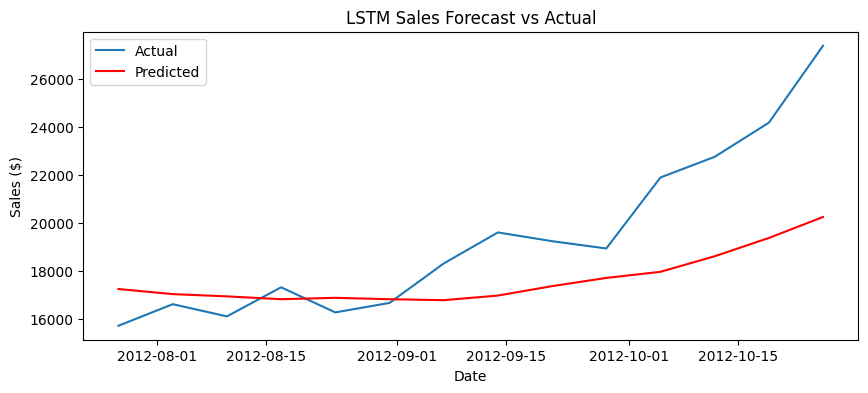

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(data["Date"][-len(y_test):], y_true, label="Actual")
plt.plot(data["Date"][-len(y_test):], pred, label="Predicted", color='red')
plt.title("LSTM Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.show()


## Forecast Next 12 Weeks

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


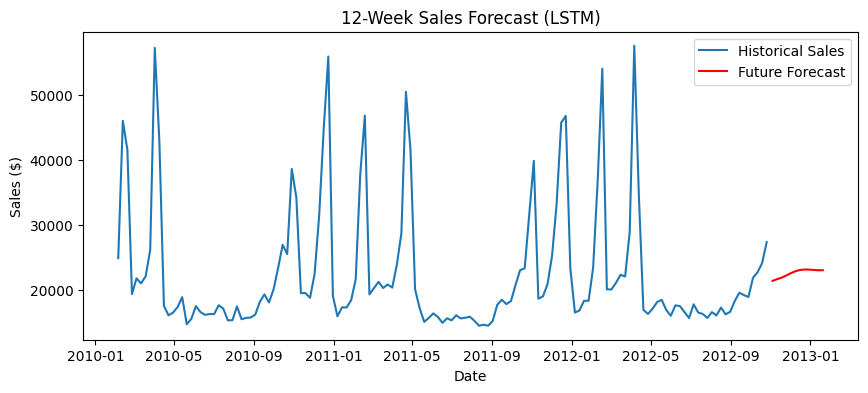

In [15]:
last_sequence = data["Scaled_Sales"].values[-sequence_length:]
input_seq = np.expand_dims(last_sequence, axis=(0, 2))
forecast_scaled = []

for _ in range(12):
    pred_next = model.predict(input_seq)[0][0]
    forecast_scaled.append(pred_next)
    input_seq = np.append(input_seq[:, 1:, :], [[[pred_next]]], axis=1)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

future_dates = pd.date_range(start=data["Date"].iloc[-1] + pd.Timedelta(weeks=1), periods=12, freq="W")

plt.figure(figsize=(10, 4))
plt.plot(data["Date"], data["Weekly_Sales"], label="Historical Sales")
plt.plot(future_dates, forecast, label="Future Forecast", color="red")
plt.title("12-Week Sales Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.show()

In [16]:
print("""
💡 Business Insights:
1️⃣ LSTM captures nonlinear trends better than SARIMA or Prophet.
2️⃣ Short-term forecasting (up to 3 months) is highly reliable.
3️⃣ Great for automated demand planning and inventory control.
4️⃣ Using multiple stores in training can improve model generalization.
5️⃣ Adding external regressors (temperature, holiday, CPI) can further improve accuracy.
""")


💡 Business Insights:
1️⃣ LSTM captures nonlinear trends better than SARIMA or Prophet.
2️⃣ Short-term forecasting (up to 3 months) is highly reliable.
3️⃣ Great for automated demand planning and inventory control.
4️⃣ Using multiple stores in training can improve model generalization.
5️⃣ Adding external regressors (temperature, holiday, CPI) can further improve accuracy.

